In [18]:
cd ../../nkono/IVC_MDE

/projectnb/cs585bp/nkono/IVC_MDE


In [1]:
import os
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt

from torch.utils.data import Dataset
from PIL import Image
import glob

from torchvision import models
import tqdm

import time
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import Resize, Compose, ToPILImage, ToTensor
import pickle
import math
import random
from torchvision.transforms import RandomCrop
#os.chdir('/projectnb/cs585bp/jkoh/')
#from SILog import SILogLoss
#os.chdir('/projectnb/cs585bp/krishna/project/')
from SILog import SILogLoss
OUT_SIZE = (2200, 1550)

In [2]:
def gradient_difs(output, target):
    #roll
    out_roll_2 = torch.roll(output,1,2)
    out_roll_3 = torch.roll(output,1,3)
    tar_roll_2 = torch.roll(target,1,2)
    tar_roll_3 = torch.roll(target,1,3)
    
    #get gradients
    out_grad_2 = output - out_roll_2
    out_grad_3 = output - out_roll_3
    tar_grad_2 = target - tar_roll_2
    tar_grad_3 = target - tar_roll_3
    
    #gradient diffs
    grad_2_dif = (out_grad_2 - tar_grad_2)**2
    grad_3_dif = (out_grad_3 - tar_grad_3)**2
    
    grad_dif = torch.mean(grad_2_dif + grad_3_dif)
    
    return grad_dif

In [3]:
## a pretty function, but it doesn't work :(
    ##our model doesn't do exactly half upscaling because the dimensions aren't powers of 2. using resize instead

def reduce_tensor(input_tensor, scale_down = 2, mode = "mean"):
    """
    mode can be mean, max, or min
    """
    batch, _, input_w, input_h = input_tensor.shape
    output_w = int(input_w/scale_down)
    output_h = int(input_h/scale_down)

    output_tensor = input_tensor.view(batch,scale_down**2,output_w,output_h)
    
    if mode == "mean":
      output_tensor = output_tensor.mean(dim=1)

    #if mode == "min":
     # output_tensor = torch.min(output_tensor,1)

    #if mode == "max":
     # output_tensor = output_tensor.max(dim=1)
    
    output_tensor = output_tensor.unsqueeze(1)
    
    return output_tensor

In [3]:
i_t = torch.ones((1,1,2200,1550))
r = reduce_tensor(i_t, scale_down = 2)
r.shape
t = transforms.Resize((500,200))(i_t)
t.shape

torch.Size([1, 1, 500, 200])

In [4]:
transforms.Resize(OUT_SIZE)

Resize(size=(2200, 1550), interpolation=bilinear, max_size=None, antialias=None)

In [5]:
c = torch.ones(1,5,10,10)
c.shape
c[:,-1,:,:].unsqueeze(1).shape

torch.Size([1, 1, 10, 10])

In [4]:
class MonocularDepthDataset(Dataset):
    def __init__(self, df, in_transform=None,out_transform = None ):
        self.df = df
        self.in_transform = in_transform
        self.out_transform = out_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image']
        depth_path = self.df.iloc[idx]['depth']

        image = Image.open(image_path)
        depth = Image.open(depth_path)
        
        sam_path = self.df.iloc[idx]['image']
        sam_path = sam_path.split('/')
        sam_path[0] = 'sam_outputs/mask/'
        sam_path = ''.join(sam_path)
        sam = Image.open(sam_path)

        #torch.Size([1, 1, 2200, 1550])
        #torch.Size([1, 1, 1098, 773]) #d_0
        #torch.Size([1, 1, 550, 388]) #d_1
        #torch.Size([1, 1, 275, 194]) #d_2
        #torch.Size([1, 1, 138, 97]) #d_3
        #torch.Size([1, 1, 69, 49]) #d_4
        d_0 = depth.resize((773, 1098))#((1098, 773))#(depth)
        d_1 = depth.resize((388, 550))#((550, 388))#(depth)
        d_2 = depth.resize((194, 275))#((275, 194))#(depth)
        d_3 = depth.resize((97, 138))#((138, 97))#(depth)
        d_4 = depth.resize((49,69))#((69, 49))#(depth)



        if self.in_transform:
            image = self.in_transform(image)
            sam = self.in_transform(sam)
        if self.out_transform:
            depth = self.out_transform(depth)
            to_tensor = transforms.ToTensor()
            d_0 = to_tensor(d_0)
            d_1 = to_tensor(d_1)
            d_2 = to_tensor(d_2)
            d_3 = to_tensor(d_3)
            d_4 = to_tensor(d_4)
        #print(depth_path,depth.shape)
        
        return image, depth, d_0, d_1, d_2, d_3, d_4, sam

In [5]:
def conv_relu_block(in_channel,out_channel,kernel,padding):
    return nn.Sequential(
            nn.Conv2d(in_channel,out_channel, kernel_size = kernel, padding=padding),
            nn.ReLU()) #nn.ReLU(inplace=True) #nn.Ge

In [6]:
class vanilla_unet_early_exit(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.input_1 = conv_relu_block(3,3,3,1) ##grayscale inputs
        #self.input_2 = conv_relu_block(64, 64, 3, 1) #no extra channels

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.l0 = nn.Sequential(*self.base_layers[:3])
        self.U0_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up0 = conv_relu_block(64 + 256, 128, 3, 0)

        self.l1 = nn.Sequential(*self.base_layers[3:5])
        self.U1_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up1 = conv_relu_block(64 + 256, 256, 3, 1)

        self.l2 = self.base_layers[5]
        self.U2_conv = conv_relu_block(128, 128, 1, 0)
        self.conv_up2 = conv_relu_block(128 + 512, 256, 3, 1)

        self.l3 = self.base_layers[6]
        self.U3_conv = conv_relu_block(256, 256, 1, 0)
        self.conv_up3 = conv_relu_block(256 + 512, 512, 3, 1)

        self.l4 = self.base_layers[7]
        self.U4_conv = conv_relu_block(512, 512, 1, 0)

        self.conv_up4 = conv_relu_block(64 + 128, 64, 3, 1)

        self.out4 = nn.Conv2d(128, n_class, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, sam):
        x = torch.cat([x,sam,x], axis = 1)
        x = self.input_1(x)
        
        #print(x.shape,'x')
         #concat on channel
        #x_one = self.input_2(x_one)
        block0 = self.l0(x)
        block1 = self.l1(block0)
        block2 = self.l2(block1)
        block3 = self.l3(block2)
        block4 = self.l4(block3)

        block4 = self.U4_conv(block4)
        b4_out = block4[:,-1,:,:].unsqueeze(1)
        #print(b4_out.shape, "block_4")
        x = nn.Upsample(size = (138,97), mode='bilinear', align_corners=True)(block4)
        block3 = self.U3_conv(block3)
        
        x = torch.cat([x, block3], axis=1)
        
        x = self.conv_up3(x)

        b3_out = x[:,-1,:,:].unsqueeze(1)
        #print(b3_out.shape, "block3")
        x = nn.Upsample(size = (275,194), mode='bilinear', align_corners=True)(x)
        
        block2 = self.U2_conv(block2)
        
        #print(x.shape, block2.shape)
        x = torch.cat([x, block2], axis=1)
        
        x = self.conv_up2(x)
        b2_out = x[:,-1,:,:].unsqueeze(1)
        #print(b2_out.shape, "block2")
        x = nn.Upsample(size = (550,388), mode='bilinear', align_corners=True)(x)
        block1 = self.U1_conv(block1)
        #print(x.shape, block1.shape)
        
        x = torch.cat([x, block1], axis=1)
        
        x = self.conv_up1(x)
        b1_out = x[:,-1,:,:].unsqueeze(1)
        #print(b1_out.shape, "block1")
        x = nn.Upsample(size = (1100, 775), mode='bilinear', align_corners=True)(x) 
        block0 = self.U0_conv(block0)

        #print(x.shape, block0.shape)
        x = torch.cat([x, block0], axis=1)

        
        x = self.conv_up0(x)
        b0_out = x[:,-1,:,:].unsqueeze(1)
        #print(b0_out.shape, "block0")
        out4 = self.out4(x)

        out4_upsampled = F.interpolate(out4, size=OUT_SIZE, mode='bilinear', align_corners=True)
        
        out = out4_upsampled
        
        
        return out, b0_out, b1_out, b2_out, b3_out, b4_out

In [9]:
m = vanilla_unet_early_exit(n_class=1)
input = torch.zeros((1,1,2200,1550))

o = m.forward(input)
for i in o:
  print(i.shape)

/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 2200, 1550])
torch.Size([1, 1, 1098, 773])
torch.Size([1, 1, 550, 388])
torch.Size([1, 1, 275, 194])
torch.Size([1, 1, 138, 97])
torch.Size([1, 1, 69, 49])


In [7]:
model = vanilla_unet_early_exit(n_class=1)
model = nn.DataParallel(model)
model = model.to('cuda')

/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
cd ../../krishna/project

/projectnb/cs585bp/krishna/project


In [9]:
# Set hyperparameters, dataset paths, and other configurations
batch_size = 3
learning_rate = 0.001
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_transform = transforms.Compose([
    transforms.Resize(OUT_SIZE),
    transforms.ToTensor()
])

out_transform = transforms.Compose([
    transforms.Resize(OUT_SIZE),
    transforms.ToTensor()
])

df = pd.read_csv('train.csv')
train_dataset = MonocularDepthDataset(df, in_transform = in_transform, out_transform = out_transform)
#val_dataset = MonocularDepthDataset(val_image_paths, val_depth_paths, transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


criterion = SILogLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
losses = []
for epoch in tqdm.notebook.tqdm(range(num_epochs)):
    #train_loss = train(model, train_dataloader, optimizer, criterion, device)
    
    model.train()
    running_loss = 0.0
    n = 0
    for images, depths, d_0, d_1, d_2, d_3, d_4, sam in tqdm.notebook.tqdm(train_dataloader):
        images = images.to(device)
        depths = depths.to(device)
        sam = sam.to(device)
        d_0 = d_0.to(device)
        d_1 = d_1.to(device)
        d_2 = d_2.to(device)
        d_3 = d_3.to(device)
        d_4 = d_4.to(device)
        
        optimizer.zero_grad()

        out, b0_out, b1_out, b2_out, b3_out, b4_out = model(images, images)
        #print('out shape',outputs.shape)
        loss_pred = criterion(out, depths) ##output,targets
        
        loss_grad = gradient_difs(out, depths)
        
        loss_0 = criterion(b0_out, d_0)#.permute(0,1,3,2)
        loss_1 = criterion(b1_out, d_1)
        loss_2 = criterion(b2_out, d_2)
        loss_3 = criterion(b3_out, d_3)
        loss_4 = criterion(b4_out, d_4)
        loss = loss_pred + loss_0 + loss_1 + loss_2 + loss_3 + loss_4 + loss_grad**0.5


        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #n += 1
        #if n > 50 : break
    #dataiter = iter(train_dataloader)
    #example = next(dataiter)
    #target = example[1]
    #example = example[0]
    #print(example.shape)
    #ex_in = example.cuda()
    #out_vis = model(ex_in).detach().cpu().numpy()[0][0][0]
    #print(np.max(out_vis))
    #print(out_vis.shape)
    train_loss = running_loss / len(train_dataloader)
    losses.append(train_loss)
    print('Loss: ', train_loss)
    #print(out_vis)
    #print("Train Loss:",train_loss)
    #out_vis = np.nan_to_num(np.rint((out_vis/np.max(out_vis))*255))
    
    #print(out_vis)
    #plt.imshow(out_vis, interpolation='nearest', cmap='gray')
    #plt.title("Output")
    #plt.show()
    #plt.imshow(example[0][0][0].detach().numpy(), cmap='gray')
    #plt.show()
    #plt.title("target")
    #target = target[0][0].detach().numpy()
    #plt.imshow(np.rint((target/np.max(target))*255), cmap='gray')
    #plt.show()

    #val_loss = validate(model, val_dataloader, criterion, device)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1779.817201345559


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1763.1579399364907


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1771.5241558919818


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1762.415429134497


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1763.7803486049575


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1764.8615296639052


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1757.0531039654009


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1755.7787590282876


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1756.958682885906


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1754.1925519904835


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1752.4207911139367


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1751.1009723228096


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1748.2666710975186


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1746.859655188234


  0%|          | 0/596 [00:00<?, ?it/s]

Loss:  1746.6665885976497


In [10]:
cd ../../nkono/IVC_MDE

/projectnb/cs585bp/nkono/IVC_MDE


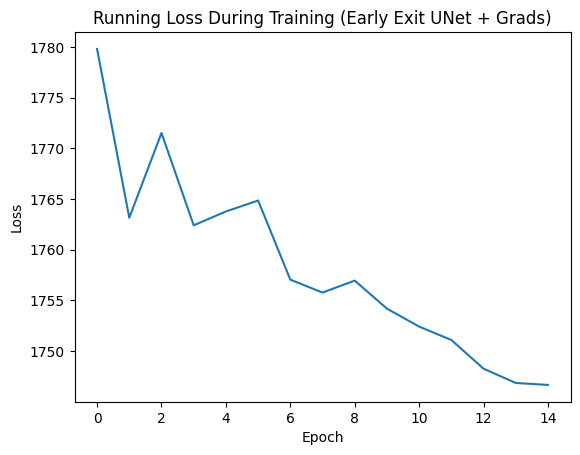

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Running Loss During Training (Early Exit UNet + Grads)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.savefig('early_exit_unet_grad_diffs.png')
torch.save(model.state_dict(), 'early_exit_unet_grad_diffs.pt')

In [13]:
model = model.load_state_dict(torch.load('early_exit_unet_grad_diffs.pt'))